# Assignment 2 - Symbolic Library Learning

Note: this notebook is adapted from the work of Kavi Gupta, Atharva Sehgal, Maddy Bowers and Armando Solar-Lezama, all rights go to them.


In this assignment we will try to come up with a DSL (Domain Specific Library) of functions.
We will play around with a library called neurosym-lib, which provides a lot of tools to do neuro-symbolic program synthesis.

In our case, we will keep things simple: we will find programs specified by our DSL that best fit some data via program enumeration. We will then try to understand how abstractions learning can help with this process.

## Outline

- Part 1: Defining a DSL (4 points)
- Part 2: Finding Programs (3 points)
- Part 3: Abstraction Learning (3 points)

In [1]:
! pip install neurosym 
# %pip install neurosym - might have to use this line instead if run locally
# Note: make sure your python version is >= 3.10 or the import will not work!

In [2]:
# check python version is >=3.10
!python --version

Python 3.11.14


In [1]:
import itertools
import neurosym as ns
import numpy as np
import matplotlib.pyplot as plt

/home/bottle/miniconda3/envs/dat615/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Defining a DSL (4 points)

We would like to be able to define arithmetic functions, of various types.

### Exercise 1A: Create a DSL

We would like our DSL to be able to represent the following functions. **For future experiments, make sure you don't include cosine.**

- $f_0(x) = x + 1$
- $f_1(x) = x^2 + \frac{x}{\sin x}$
- $f_2(x) = (x + 2)^x$
- $f_3(x) = \begin{cases}
x^2 & x < 0\\
\sqrt {x^2 + 1} & x \geq 0\\
\end{cases}$

To add a new symbol to the DSL grammar, you should use the function `dslf.production()`.
Here is a description of that function:

    production(self, symbol: str, type_str: str, semantics: object)
        Add a parameterized production to the DSL.

        :param symbol: The symbol for the production.
        :param type_str: The type string for the production.
        :param semantics: The semantics to use for the production. This should have
            a type corresponding to ``type_str``. Note: *this is not checked*.

Meaning that the first parameter is the symbol you will use for the DSL primitive, the second is the type of the function, and the third is the actual python function implementation (using numpy functions here can be useful).

We have defined an incomplete DSL grammar below. Your task is to extend it so all of the examples above can be expressed.

**Hint 1**: try adding at least one new constant symbol, one or more binary operators, and one ternary operator (if-else) that appear in the above example to the DSL grammar.

**Hint 2**: for the if-else operator, we suggest making a general if-else of type $(c, f, f) \rightarrow f$. The first argument should be a conditional expression of type c (a boolean), such as "x > 0" in the example above. The two remaining arguments (of type f) should be the two alternatives of the if-else returned depending on whether the first argument is true or false.

Then, a specific if-else expression like the one shown in the above example can be constructed by choosing the first parameter of the if-else to be a specific conditional expression (e.g. using the "<" function provided, of type (f, f) -> c)

In [2]:
dslf = ns.DSLFactory()
dslf.production("0", "() -> f", lambda: 0) # constant 0, no arguments
dslf.production("1", "() -> f", lambda: 1)
dslf.production("2", "() -> f", lambda: 2)
dslf.production("sqrt", "(f) -> f", np.sqrt) # square root, one argument
dslf.production("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
dslf.production("<", "(f, f) -> c", lambda x,y: x < y) # less than, two arguments, returns a boolean

"YOUR CODE HERE"
dslf.production("+", "(f, f) -> f", lambda x, y: x + y)
dslf.production("**", "(f, f) -> f", lambda x, y: x**y)
dslf.production("/", "(f, f) -> f", lambda x, y: x / y)
dslf.production("sin", "(f) -> f", np.sin)
dslf.production("tan", "(f) -> f", np.tan)
dslf.production("ife", "(c, f, f) -> f", lambda c, x, y : x if c else y )

dslf.lambdas()
dslf.prune_to("f -> f")
dsl = dslf.finalize()

### DSL Printout

See your DSL printed below, and ensure it is what you would expect!

In [3]:
print(dsl.render())

              0 :: () -> f
              1 :: () -> f
              2 :: () -> f
           sqrt :: f -> f
              * :: (f, f) -> f
              < :: (f, f) -> c
              + :: (f, f) -> f
             ** :: (f, f) -> f
              / :: (f, f) -> f
            sin :: f -> f
            tan :: f -> f
            ife :: (c, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>


### Exercise 1B: Write your functions

We have provided $f_0$, it is up to you to write $f_1$ through $f_3$.

How you represent your functions is by putting their symbol first, then their arguments afterwards. E.g. for the function x + 1, we get the function sum and add the parameters after, resulting in: \+ x 1. Here both x and 1 are functions with no inputs, so we can report them like this

Note that $0_0 represents the input variable x. Be sure to use in the other functions as well. Also remember the parenthesis like we have in the example below.

In [4]:
f_0 = "(lam (+ ($0_0) (1)))"
"YOUR CODE HERE"
f_1 = "(lam (+ (** ($0_0) (2)) (/ ($0_0) (sin ($0_0)))))"
f_2 = "(lam (** (+ ($0_0) (2)) ($0_0)))"
f_3 = "(lam (ife (< ($0_0) (0)) (** ($0_0) (2)) (sqrt (+ (** ($0_0) (2)) (1)))))"


Run the tests in the following cell to make sure your DSL and programs are working properly. If you have not defined the functions correctly, you will get an AssertionError.

In [6]:
def test_program(actual_program, expected_fn):
    actual_fn = dsl.compute(dsl.initialize(ns.parse_s_expression(actual_program)))
    inputs = np.linspace(-1, 1, 100)
    actual = np.array([actual_fn(x) for x in inputs])
    expected = np.array([expected_fn(x) for x in inputs])
    delta = np.abs(actual - expected)
    bad = delta > 1e-5
    if (~bad).all():
        return
    [[bad_input, *_]] = np.where(bad)
    raise AssertionError(f"On input {inputs[bad_input]}, expected {expected[bad_input]} but recvd {actual[bad_input]}")

test_program(f_0, lambda x: x + 1)
test_program(f_1, lambda x: x ** 2 + x / np.sin(x))
test_program(f_2, lambda x: (x + 2) ** x)
test_program(f_3, lambda x: x ** 2 if x < 0 else (x ** 2 + 1) ** 0.5)
print("All tests passed!")


All tests passed!


## Part 2: Finding Programs (3 points)

To begin with, we will build programs with our DSL by enumerating them. We will sample uniformly terms from our library, forming programs from this.

In [7]:
dist_family = ns.BigramProgramDistributionFamily(dsl)
uniform = dist_family.uniform()

We can enumerate programs from this distribution by running the `dist_family.enumerate` command.
This produces an infinite stream of programs, which we can limit with `islice` as below:

In [8]:
for prog, like in itertools.islice(dist_family.enumerate(uniform), 50):
    print(ns.render_s_expression(prog), like)

(lam ($0_0)) -2.4849066734313965
(lam (0)) -2.4849066734313965
(lam (1)) -2.4849066734313965
(lam (2)) -2.4849066734313965
(lam (sin ($0_0))) -4.969813346862793
(lam (sin (0))) -4.969813346862793
(lam (sin (1))) -4.969813346862793
(lam (sin (2))) -4.969813346862793
(lam (sqrt ($0_0))) -4.969813346862793
(lam (sqrt (0))) -4.969813346862793
(lam (sqrt (1))) -4.969813346862793
(lam (sqrt (2))) -4.969813346862793
(lam (tan ($0_0))) -4.969813346862793
(lam (tan (0))) -4.969813346862793
(lam (tan (1))) -4.969813346862793
(lam (tan (2))) -4.969813346862793
(lam (* ($0_0) ($0_0))) -7.4547200202941895
(lam (* ($0_0) (0))) -7.4547200202941895
(lam (* ($0_0) (1))) -7.4547200202941895
(lam (* ($0_0) (2))) -7.4547200202941895
(lam (* (0) ($0_0))) -7.4547200202941895
(lam (* (0) (0))) -7.4547200202941895
(lam (* (0) (1))) -7.4547200202941895
(lam (* (0) (2))) -7.4547200202941895
(lam (* (1) ($0_0))) -7.4547200202941895
(lam (* (1) (0))) -7.4547200202941895
(lam (* (1) (1))) -7.4547200202941895
(lam 

What are the programs with the highest likelihood? Can you briefly explain why?

**Your answer:** 

From the enumeration we can see that the programs with the highest likelihood is 

(lam ($0_0)) -2.4849066734313965

(lam (0)) -2.4849066734313965

(lam (1)) -2.4849066734313965

(lam (2)) -2.4849066734313965

The general trend seems to be that shorter programs have a higher likelihood. This make sense since they have composible choices which leads to fewer multiplications of probabilities. 



### Exercise 2: Finding a program

Finish the following function below, which, given a distribution, a list of inputs and a list of outputs, finds a program matching those inputs and outputs, within epsilon at all locations. It might be helpful to look at the `test_program` method above to see how to run programs.

Important detail: you will want to handle errors and `nan` values gracefully. For this, we provide the `run_safely` function, that takes a function and input and runs it, returning `None` if its output is `nan` or an error.

In [9]:
import warnings
warnings.filterwarnings('ignore') # suppress warnings about run-time errors we catch.


def run_safely(f, x):
    try:
        y = f(x)
    except:
        return None
    if np.isnan(y):
        return None
    return y

def find_program(dist, inputs, outputs, epsilon):
    for prog, _ in dist_family.enumerate(dist):
        fn = dsl.compute(dsl.initialize(prog))
        bad = False
        # Now you can use fn to safely evaluate the program at each input in inputs,
        # and compare the output you get from fn(input) to the correpsonding y in outputs
        actual = np.array([run_safely(fn, x) for x in inputs])
        for i in range(len(actual)):
            # If the program returns None (from run_safely) or is not within epsilon for all expected outputs, it is not your program, continue searching. Otherwise, it's our program!
            if actual[i] == None or np.abs(actual[i] - outputs[i]) > epsilon:
                bad = True
                break
        if bad:
            continue

        return prog


Let's look at what types of programs our search is finding for some functions we provide!

In [10]:
def find_program_for_function(dist, fn, epsilon):
    inputs = np.linspace(-2, 2)
    outputs = fn(inputs)
    return find_program(dist, inputs, outputs, epsilon)

print(ns.render_s_expression(find_program_for_function(uniform, lambda x: x * 2, 0)))
print(ns.render_s_expression(find_program_for_function(uniform, np.abs, 0.001)))
print(ns.render_s_expression(find_program_for_function(uniform, lambda x: x + 0.05, 0.1)))
print(ns.render_s_expression(find_program_for_function(uniform, lambda x: x ** 2, 0.1)))
print(ns.render_s_expression(find_program_for_function(uniform, lambda x: (x ** 2 + 1) ** 0.5, 0.1)))

(lam (* ($0_0) (2)))
(lam (sqrt (* ($0_0) ($0_0))))
(lam ($0_0))
(lam (* ($0_0) ($0_0)))
(lam (sqrt (+ (* ($0_0) ($0_0)) (1))))


Run the tests to assure that the programs you are finding are the expected ones:

In [11]:
assert ns.render_s_expression(find_program_for_function(uniform, lambda x: x * 2, 0)) == '(lam (* ($0_0) (2)))'
assert ns.render_s_expression(find_program_for_function(uniform, np.abs, 0.001)) == '(lam (sqrt (* ($0_0) ($0_0))))'
assert ns.render_s_expression(find_program_for_function(uniform, lambda x: x + 0.05, 0.1)) == '(lam ($0_0))'

You will notice in the second test above, the enumerator came up with a "creative" solution to the absolute value problem. This is because this ended up being an easier to find solution than the more obvious if-then-else program we might have come up, given our DSL:

 -x if x < 0 else x

which in the DSL syntax, given some functions ite (if-then-else), < and - are defined, looks like:

 `(lam (ite (< ($0_0) (0)) (- (0) ($0_0)) ($0_0)))`



The following cell will take slightly longer to run, but you can see that it is able to identify a solution for $\cos^2 \theta$

Note: depending on your CPU, the search for $\cos^2 \theta$ might time out. If it does, don't worry about it. It is not needed for the remainder of the assignment.

In [ ]:
ns.render_s_expression(find_program_for_function(uniform, lambda x: np.cos(x) ** 2, 0.001))

What primitive do we need to add to our library to be able to find a program for $\cos \theta$? (Remember, you are not allowed to add directly $\cos$! Think back to trigonometric formulas...) Go back to where you have defined your DSL and add it, then come back to the next cell.

Note: the time it takes to find a program for $\cos \theta$ will depend on the exact DSL grammar as well as the CPU used. In our tests we observed the following search times:
- on an Apple M4 CPU: between 7 seconds and 7 min;
- on Colab: at least 28 seconds.

In [13]:
ns.render_s_expression(find_program_for_function(uniform, lambda x: np.cos(x), 0.001))

'(lam (/ (sin ($0_0)) (tan ($0_0))))'

What did you add?

Your answer: $\tan \theta$

## Part 3: Abstraction Learning (3 points)

Here we will try to understand how we can do better than just sampling programs uniformly at random when we have some data we want to find programs for, and how abstractions can help within this process.

We start by introducing a dataset of smoothed sequences. These sequences have values roughly in the range $[-2, 2]$. We generate this data below:

In [12]:
num_sequences = 1000
len_sequences = 100
xs = np.linspace(-10, 10, len_sequences, dtype=np.float32)
slack = 20
stride = 4
values = np.random.RandomState(1).rand(num_sequences, len_sequences + slack) * 4 - 2
values = np.mean([values[:, i:i + len_sequences] for i in range(slack)], axis=0)
values *= np.sqrt(slack)
values = values[:, ::stride]
values = values.astype(np.float32)
xs = xs[::stride]

plot_count = 3

def plot_some_sequences():
    for i in range(plot_count):
        plt.plot(xs, values[i], color=f"C{i}", alpha=0.25)
        plt.scatter(xs, values[i], color=f"C{i}", marker=".")

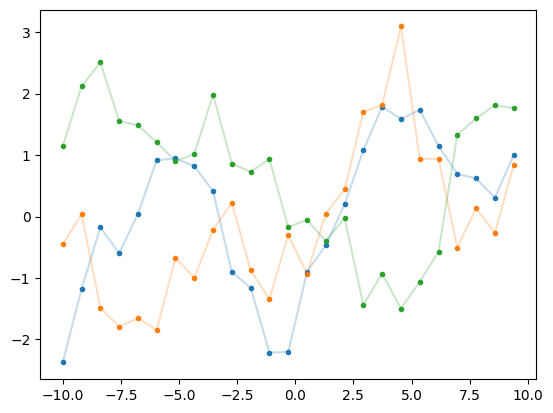

In [13]:
plot_some_sequences()

We provide a function for finding the best program out of a list that matches a given data sequence:

In [14]:
def evaluate_all_programs(dsl, programs):
    filtered_programs, evaluations = [], []
    for prog in programs:
        try:
            actual_fn = dsl.compute(dsl.initialize(prog))
        except:
            continue
        ys = []
        for inp in xs:
            y = run_safely(actual_fn, inp)
            if y is None or not (-2 <= y <= 2):
                break
            ys.append(y)
        else:
            filtered_programs.append(prog)
            evaluations.append(ys)
    return filtered_programs, np.array(evaluations)

def best_fits(dsl, family, dist):
    programs = [prog for prog, _ in itertools.islice(family.enumerate(dist), 5000)]
    programs = sorted(programs, key=lambda x: len(ns.render_s_expression(x)))
    filtered_programs, ys = evaluate_all_programs(dsl, programs)
    errors = ((ys[None] - values[:,None]) ** 2).sum(-1)
    program_idxs = errors.argmin(1)
    print("Mean error: ", errors.min(1).mean())
    return [filtered_programs[i] for i in program_idxs]

def plot_programs_against_data(dsl, best_programs):
    plot_some_sequences()
    best_programs = best_programs[:plot_count]
    _, evals = evaluate_all_programs(dsl, best_programs)
    for prog, ev in zip(best_programs, evals):
        plt.plot(xs, ev, label=ns.render_s_expression(prog).replace("$", r"\$"))
    plt.legend()

Now we find the best programs among the first 50k enumerated programs

In [15]:
best_programs = best_fits(dsl, dist_family, uniform)

Mean error:  21.159363209577602


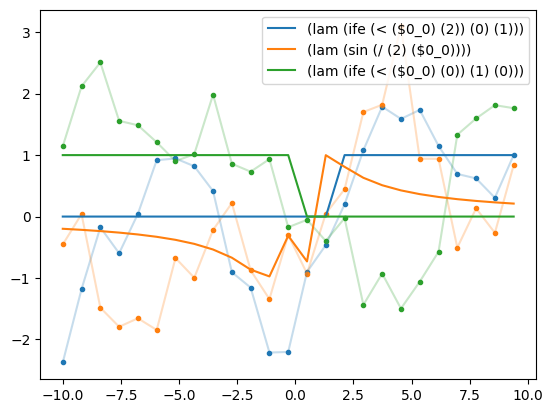

In [16]:
plot_programs_against_data(dsl, best_programs)

### Exercise 3A: Fitting a DSL

Now we will refine our search. First, we fit a distribution to the `best_programs`. We will bound the minimum likelihood of each symbol at 0.01, but feel free to try and change it. If you do so, comment on the result:

...

Check with the functions defined above how the mean error changes now that we have fitted the distribution to the best programs, and plot the new programs like above:

In [17]:
fitted_dist = dist_family.fit_distribution(best_programs).bound_minimum_likelihood(0.01)


In [18]:
# Check that the fitted distribution actually makes the error smaller

best_programs_fitted = best_fits(dsl, dist_family, fitted_dist)

Mean error:  15.962358179787813


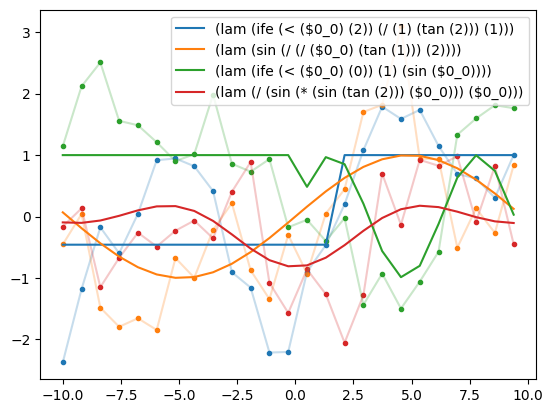

In [19]:
# Plot the best programs
plot_count = 4
plot_programs_against_data(dsl, best_programs_fitted)

### Exercise 3B: Abstractions

Let's now introduce abstractions to our DSL. This means going through the best programs we have already found, find common subsequences, and abstract them into new symbols of our DSL.

We will introduce 5 new abstractions. Once done, obtain a new distribution family from the new DSL as we have done before, and then fit a distribution from that family to the rewritten programs. Bound also that distribution to a minimum likelihood of 0.01:

In [20]:
abstraction_dsl, rewritten = ns.compression.multi_step_compression(dsl, best_programs_fitted, 5)
abstraction_family = ns.BigramProgramDistributionFamily(abstraction_dsl)
abstraction_dist = abstraction_family.fit_distribution(rewritten).bound_minimum_likelihood(0.01)


Visualize your dsl and the new abstractions that have been introduced.

In [21]:
# visualize dsl
print(abstraction_dsl.render())

              0 :: () -> f
              1 :: () -> f
              2 :: () -> f
           sqrt :: f -> f
              * :: (f, f) -> f
              < :: (f, f) -> c
              + :: (f, f) -> f
             ** :: (f, f) -> f
              / :: (f, f) -> f
            sin :: f -> f
            tan :: f -> f
            ife :: (c, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>
           __10 :: () -> f = (lam-abstr () (tan (2)))
           __20 :: (f, f) -> f = (lam-abstr (#0 #1) (sin (/ #1 #0)))
           __30 :: (f, f) -> f = (lam-abstr (#0 #1) (sin (* (sin #1) #0)))
           __40 :: () -> f -> f = (lam-abstr () (lam (sin (tan (ife (< ($0_0) (2)) (0) (2))))))
           __50 :: () -> f -> f = (lam-abstr () (lam (ife (< ($0_0) (2)) (/ ($0_0) (tan (sqrt (2)))) (0))))


Can you understand which functions do the abstractions introduced refer to? (Note: #number in the definition of the abstraction refer to a input parameter.)

Your answer:

1. $f() = \tan(2)$

2. $f(x,y) = \sin(\frac{x}{y})$

3. $f(x, y) = \sin(x\sin(y))$

4. $f(x) = \begin{cases} 0 \; &x \lt 2 \\ \sin(\tan(2)) \; &x \geq 2 \end{cases}$  

5. $f(x) = \begin{cases} \frac{x}{\tan(\sqrt{2})} \; &x \lt 2 \\ 0 \; &x \geq 2 \end{cases}$

Now check that the abstractions have had a positive effect to the mean error.

In [22]:
best_programs_abstractions = best_fits(abstraction_dsl, abstraction_family, abstraction_dist)

Mean error:  13.95662996838539


Finally, let's plot some programs against the data and see how they fit:

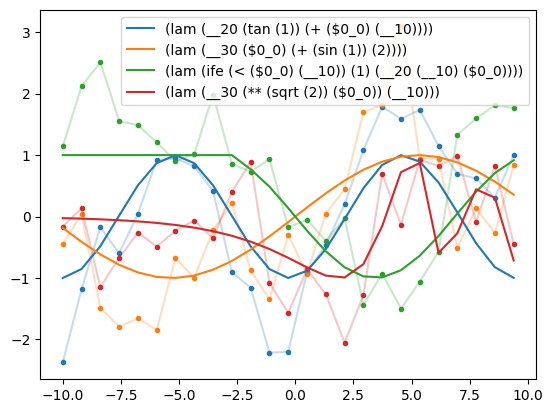

In [23]:
plot_programs_against_data(abstraction_dsl, best_programs_abstractions)

Hopefully, by now you understand how abstractions are important and how they make it easier to find better and better programs the more we intertwine search and introduction of abstractions.

We search for programs, introduce abstractions, find better programs with the abstractions, then introduce more asbtractions... and so on! Dreamcoder, which you have seen in the lectures, is a great example of this mechanism, and the results they obtain in their paper (https://arxiv.org/abs/2006.08381) is a testament of how powerful methods that combine library learning with neural networks can be.